## Example notebook of scoring a sentiment dataset with a LLM using langchain
<a target="_blank" href="https://colab.research.google.com/github/rajshah4/LLM-Evaluation/blob/main/Sentiment_LLM.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%pip -q install datasets pandas openai scikit-learn seaborn matplotlib langchain

In [2]:
import datasets
import pandas as pd
import json

In [3]:
from datasets import load_dataset

dataset = load_dataset(path='financial_phrasebank',name='sentences_allagree')

In [4]:
data = dataset['train'].to_pandas()
data

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2
...,...,...
2259,Operating result for the 12-month period decre...,0
2260,HELSINKI Thomson Financial - Shares in Cargote...,0
2261,LONDON MarketWatch -- Share prices ended lower...,0
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0


In [5]:
data_sample = data.sample(20)
data_sample

,sentence,label
2140,Finnish management software solutions provider...,0
413,`` The trend in the sports and leisure markets...,2
451,- UPM-Kymmene upgraded to ` in-line ' from ` u...,2
765,The machine will have an annual production cap...,1
1507,The share capital of Basware Corporation is 11...,1
1572,"YIT CORPORATION SEPT. 24 , 2007 at 13:30 CORPO...",1
2084,Samsung currently occupies third place and los...,0
1675,Metsaliitto will sell 1.1 million B shares of ...,1
1761,The decision will have to be made whether the ...,1
1608,Cameco typically prices sales contracts using ...,1


In [6]:
import os
import openai
import getpass

open_ai_key = getpass.getpass('Enter your OPENAI API Key')
os.environ["OPENAI_API_KEY"]= open_ai_key

Enter your OPENAI API Key··········


In [7]:
from langchain.llms import OpenAI
llm = OpenAI(temperature=0.0)

In [8]:
PROMPT_TEMPLATE = """
Label the financial sentiment of the given text.

{sentence}

The answer should be exactly 'positive', 'negative', or 'neutral'. Return a JSON with the sentiment. Do not explain.
"""

In [9]:
from langchain.prompts import PromptTemplate
prompt = PromptTemplate(
        input_variables=["sentence"], template=PROMPT_TEMPLATE
    )

In [10]:
from langchain.chains import LLMChain

chain = LLMChain(llm=llm, prompt=prompt)
output = chain.run(data_sample['sentence'])
output

'\n{"2140": "neutral", "413": "neutral", "451": "positive", "765": "neutral", "1507": "neutral", "1572": "neutral", "2084": "negative", "1675": "neutral", "1761": "neutral", "1608": "neutral", "130": "neutral", "1127": "neutral", "1259": "neutral", "1314": "neutral", "1568": "positive", "1256": "neutral", "193": "neutral", "1960": "neutral", "1635": "neutral", "635": "neutral"}'

In [11]:
# Remove leading and trailing whitespace
data_string = output.strip()

# Convert the string to a DataFrame
output_df = pd.read_json(data_string, orient='index')
output_df = output_df.reset_index()
output_df.columns = ['ID', 'Sentiment']

print(output_df)

      ID Sentiment
0   2140   neutral
1    413   neutral
2    451  positive
3    765   neutral
4   1507   neutral
5   1572   neutral
6   2084  negative
7   1675   neutral
8   1761   neutral
9   1608   neutral
10   130   neutral
11  1127   neutral
12  1259   neutral
13  1314   neutral
14  1568  positive
15  1256   neutral
16   193   neutral
17  1960   neutral
18  1635   neutral
19   635   neutral


In [12]:
sentiment_mapping = {
    'neutral': 1,
    'positive': 2,
    'negative': 0  # Optional, if you have 'negative' as a sentiment label
}

output_df['Sentiment'] = output_df['Sentiment'].replace(sentiment_mapping)

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Create the confusion matrix
cm = confusion_matrix(data_sample['label'],output_df['Sentiment'])
report = classification_report(data_sample['label'], output_df['Sentiment'])

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[ 1  1  0]
 [ 0 13  1]
 [ 0  3  1]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.76      0.93      0.84        14
           2       0.50      0.25      0.33         4

    accuracy                           0.75        20
   macro avg       0.75      0.56      0.61        20
weighted avg       0.74      0.75      0.72        20



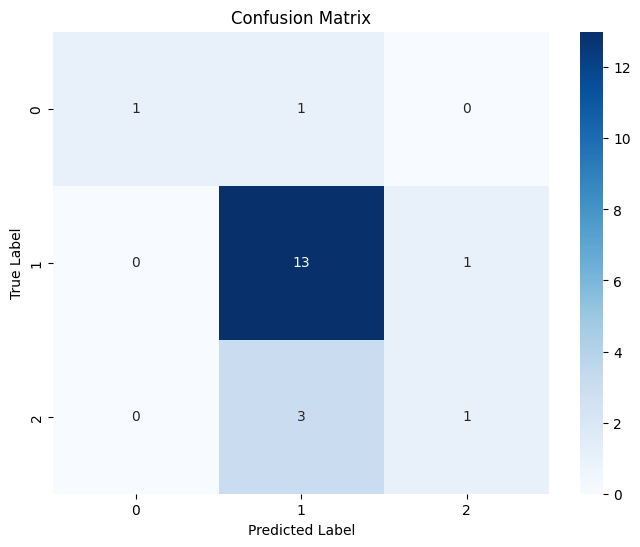

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Set the class labels
class_labels = np.unique(np.concatenate((data_sample['label'], output_df['Sentiment'])))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()